In [1]:
!pip install fbprophet
!pip install sktime
!pip install pmdarima
!pip install salesforce-merlion
!pip install -e ts_datasets

ERROR: ts_datasets is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).


In [2]:
!git clone https://github.com/salesforce/Merlion
!pip install -e /content/Merlion/ts_datasets/

fatal: destination path 'Merlion' already exists and is not an empty directory.
Obtaining file:///content/Merlion/ts_datasets
  Attempting uninstall: ts-datasets
    Found existing installation: ts-datasets 0.1.0
    Can't uninstall 'ts-datasets'. No files were found to uninstall.
  Running setup.py develop for ts-datasets


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from IPython.display import display

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [4]:
# アメリカンフットボールプレーヤのPayton ManningのWikiアクセス数
df = pd.read_csv('http://logopt.com/data/peyton_manning.csv')
display(df.head())
display(df.tail())
print(df.dtypes)
print(df.shape)

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


,ds,y
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871
2904,2016-01-20,8.891374


ds     object
y     float64
dtype: object
(2905, 2)


In [5]:
df['ds'] = pd.to_datetime(df['ds'])
print(df.dtypes)

ds    datetime64[ns]
y            float64
dtype: object


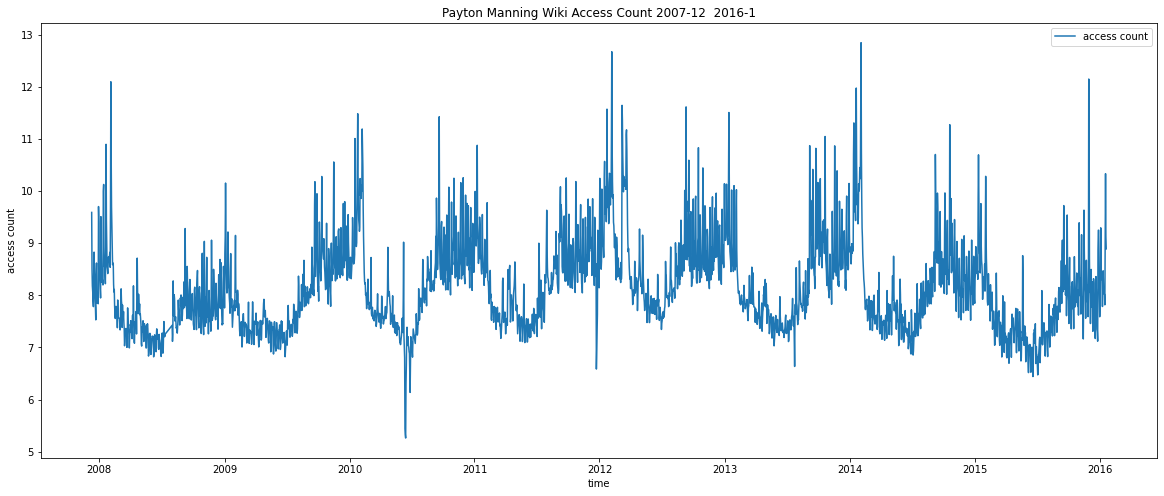

In [6]:
# グラフ表示
fig = plt.figure(figsize=(20, 8))

plt.title("Payton Manning Wiki Access Count 2007-12  2016-1")
plt.xlabel("time")
plt.ylabel("access count")

plt.plot(df["ds"], df["y"], label="access count")
plt.legend()
plt.show()

### データの分割

In [7]:
from sktime.forecasting.model_selection import temporal_train_test_split

TIME_SPAN = 90

train, test = temporal_train_test_split(df, test_size=TIME_SPAN)

In [8]:
print(train.shape, test.shape)

(2815, 2) (90, 2)


### Merlion

In [9]:
from merlion.utils import TimeSeries
from merlion.models.defaults import DefaultForecasterConfig, DefaultForecaster

In [10]:
# 参考 datasets の使用
import sys
sys.path.append("/content/Merlion/ts_datasets")

from merlion.utils import TimeSeries
from ts_datasets.forecast import M4

# Data loader returns pandas DataFrames, which we convert to Merlion TimeSeries
time_series, metadata = M4(subset="Hourly")[0]
time_series

100%|██████████| 414/414 [00:01<00:00, 390.84it/s]


,H1
1970-01-01 00:00:00,605.0
1970-01-01 01:00:00,586.0
1970-01-01 02:00:00,586.0
1970-01-01 03:00:00,559.0
1970-01-01 04:00:00,511.0
...,...
1970-01-31 23:00:00,785.0
1970-02-01 00:00:00,756.0
1970-02-01 01:00:00,719.0
1970-02-01 02:00:00,703.0


In [43]:
model = DefaultForecaster(DefaultForecasterConfig())

# データ変換
train_ts = TimeSeries.from_pd(train.set_index("ds"))
test_ts = TimeSeries.from_pd(test.set_index("ds"))

# 学習
model.train(train_data=train_ts)

# 予測データの作成
pred_merlion, test_err_merlion = model.forecast(time_stamps=test_ts.time_stamps)

pred_merlion.to_pd().head()

INFO:merlion.models.forecast.ets:Detect seasonality 7


,y
2015-10-23,8.279999
2015-10-24,7.701718
2015-10-25,8.358184
2015-10-26,8.561010
2015-10-27,8.158431


### Prophet

In [12]:
from fbprophet import Prophet

In [13]:
# モデルの作成
model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=True)

# 学習
model.fit(train)

# 予測データの作成
pred = model.predict(test)
pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-10-23,8.799383,7.411324,8.633870,8.799383,8.799383,-0.747426,-0.747426,-0.747426,-1.227055,-1.227055,-1.227055,-0.061513,-0.061513,-0.061513,0.541141,0.541141,0.541141,0.0,0.0,0.0,8.051957
1,2015-10-24,8.798167,7.223280,8.393368,8.798167,8.798167,-0.992152,-0.992152,-0.992152,-1.227055,-1.227055,-1.227055,-0.299138,-0.299138,-0.299138,0.534040,0.534040,0.534040,0.0,0.0,0.0,7.806015
2,2015-10-25,8.796952,7.548523,8.738788,8.796952,8.796952,-0.653644,-0.653644,-0.653644,-1.227055,-1.227055,-1.227055,0.049325,0.049325,0.049325,0.524086,0.524086,0.524086,0.0,0.0,0.0,8.143308
3,2015-10-26,8.795736,7.793305,9.054973,8.795736,8.795736,-0.383470,-0.383470,-0.383470,-1.227055,-1.227055,-1.227055,0.332145,0.332145,0.332145,0.511439,0.511439,0.511439,0.0,0.0,0.0,8.412266
4,2015-10-27,8.794520,7.602379,8.784839,8.794520,8.794520,-0.620700,-0.620700,-0.620700,-1.227055,-1.227055,-1.227055,0.110011,0.110011,0.110011,0.496344,0.496344,0.496344,0.0,0.0,0.0,8.173821


In [14]:
pred_prophet = pred["yhat"]

### Sktime

In [15]:
from sktime.forecasting.all import *

In [16]:
# 日時データをindexに変換
train_sk = train.set_index("ds")
test_sk = test.set_index("ds")

# 学習
model = ThetaForecaster(sp=TIME_SPAN)
model.fit(train["y"])

fh = ForecastingHorizon(test.index, is_relative=False)

# 予測データの作成
pred_sktime = model.predict(fh)

### LSTM

In [17]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [18]:
# 目的変数と説明変数の作成
def make_dataset(low_data, maxlen):

    data, target = [], []

    for i in range(len(low_data)-maxlen):
        data.append(low_data[i:i + maxlen])
        target.append(low_data[i + maxlen])

    re_data = np.array(data).reshape(len(data), maxlen, 1)
    re_target = np.array(target).reshape(len(data), 1)

    return re_data, re_target

# RNNへの入力データ数
window_size = 12

# 入力データと教師データへの分割
X, y = make_dataset(df["y"], window_size)

In [19]:
# データの分割
X_train, X_test, y_train, y_test = temporal_train_test_split(X, y, test_size=TIME_SPAN)

In [20]:
# validation データの作成
X_train, X_val, y_train, y_val = temporal_train_test_split(X_train, y_train, test_size=TIME_SPAN)

In [21]:
# ネットワークの構築
model = Sequential() # Sequentialモデル

model.add(LSTM(50, batch_input_shape=(None, window_size, 1))) # LSTM 50層
model.add(Dense(1)) # 出力次元数は1

#コンパイル
model.compile(loss='mean_squared_error', optimizer=Adam() , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


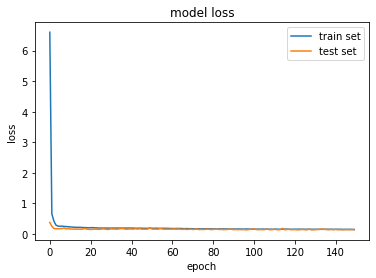

In [22]:
# 学習用パラメータ
batch_size = 20
n_epoch = 150

# 学習
hist = model.fit(X_train, y_train,
                 epochs=n_epoch,
                 validation_data=(X_val, y_val),
                 verbose=0,
                 batch_size=batch_size)

# 損失値(Loss)の遷移のプロット
plt.plot(hist.history['loss'],label="train set")
plt.plot(hist.history['val_loss'],label="test set")
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
# 予測
pred_lstm = model.predict(X_test)

### lightGBM



In [24]:
import lightgbm as lgbm

In [25]:
# 元のデータを残すため、別途コピー
df_lag = df.copy()

In [26]:
# 時系列特徴量の作成
df_lag["year"]  = df_lag["ds"].dt.year
df_lag["month"] = df_lag["ds"].dt.month
df_lag["day"]  = df_lag["ds"].dt.day
df_lag["dayofweek"] = df_lag["ds"].dt.dayofweek

In [27]:
# ラグの作成 簡単に1週間と1ヶ月で作成
for i in [7, 30]:
    df_lag[f"shift{i}"] = df_lag["y"].shift(i)

# 差分の作成
for i in [7, 30]:
    df_lag[f"deriv{i}"] = df_lag[f"shift{i}"].diff(i)

# 移動平均の作成
for i in [7, 30]:
    df_lag[f"mean{i}"] = df_lag[f"shift{i}"].rolling(12).mean()

# 中央値、最大値、最小値の作成
for i in [7, 30]:
    df_lag[f"median{i}"] = df_lag[f"shift{i}"].rolling(12).median()

for i in [7, 30]:
    df_lag[f"max{i}"] = df_lag[f"shift{i}"].rolling(12).max()

for i in [7, 30]:
    df_lag[f"min{i}"] = df_lag[f"shift{i}"].rolling(12).min()

In [28]:
# NaN部分を削除
df_lag = df_lag[41:]

In [29]:
# ds列をindexにして説明変数から除外
df_lag = df_lag.set_index("ds")

In [30]:
train_lag, test_lag = temporal_train_test_split(df_lag, test_size=TIME_SPAN)

In [31]:
# 学習
model = lgbm.LGBMRegressor()
model.fit(train_lag.drop("y", axis=1), train_lag["y"])

# 予測データの作成
pred_lgbm = model.predict(test_lag.drop("y", axis=1))

### 比較

In [32]:
compare_pred = test.reset_index()[["ds", "y"]]
compare_pred = compare_pred.rename(columns={"y":"test_data"})
compare_pred.head()

,ds,test_data
0,2015-10-23,7.860185
1,2015-10-24,7.942362
2,2015-10-25,8.198089
3,2015-10-26,8.429018
4,2015-10-27,8.056744


In [51]:
compare_pred["Merlion"] = pred_merlion.to_pd().reset_index()["y"]
compare_pred["Prophet"] = pred_prophet.reset_index()["yhat"]
compare_pred["sktime"] = pred_sktime.reset_index()[0]
compare_pred["LSTM"] = pred_lstm
compare_pred["lightGBM"] = pred_lgbm

print(compare_pred.shape)
display(compare_pred.head())

(90, 7)


,ds,test_data,Merlion,Prophet,sktime,LSTM,lightGBM
0,2015-10-23,7.860185,8.279999,8.051957,7.931248,8.061314,8.063055
1,2015-10-24,7.942362,7.701718,7.806015,8.060846,7.853265,7.661413
2,2015-10-25,8.198089,8.358184,8.143308,8.014486,8.503943,8.452949
3,2015-10-26,8.429018,8.561010,8.412266,7.938065,8.449479,8.743149
4,2015-10-27,8.056744,8.158431,8.173821,7.844981,8.241799,8.649994


R2スコア 0.2024673792611913
RMSE 0.6990555856934613


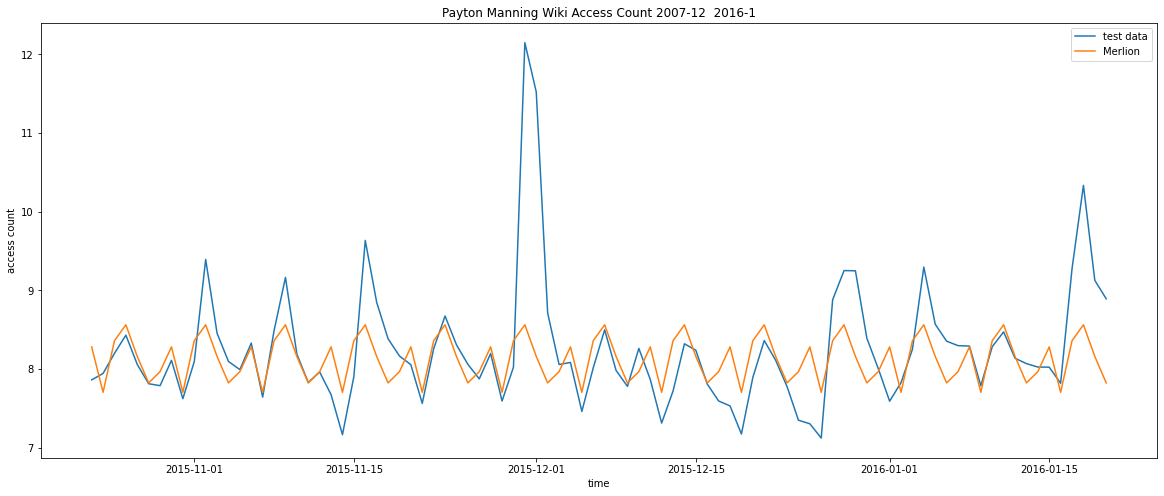

In [53]:
# Google Colab用
#@title 予測モデルを選択
dropdown = 'Merlion' #@param ["Merlion", "Prophet", "sktime", "LSTM", "lightGBM"]
print("R2スコア", r2_score(compare_pred["test_data"], compare_pred[dropdown]))
print("RMSE", np.sqrt(mean_squared_error(compare_pred["test_data"], compare_pred[dropdown])))

# 選択した予測結果と実績をグラフ表示
fig = plt.figure(figsize=(20, 8))

plt.title("Payton Manning Wiki Access Count 2007-12  2016-1")
plt.xlabel("time")
plt.ylabel("access count")

plt.plot(test["ds"], test["y"], label="test data")
plt.plot(test["ds"], compare_pred[dropdown], label=dropdown)

plt.legend()
plt.show()

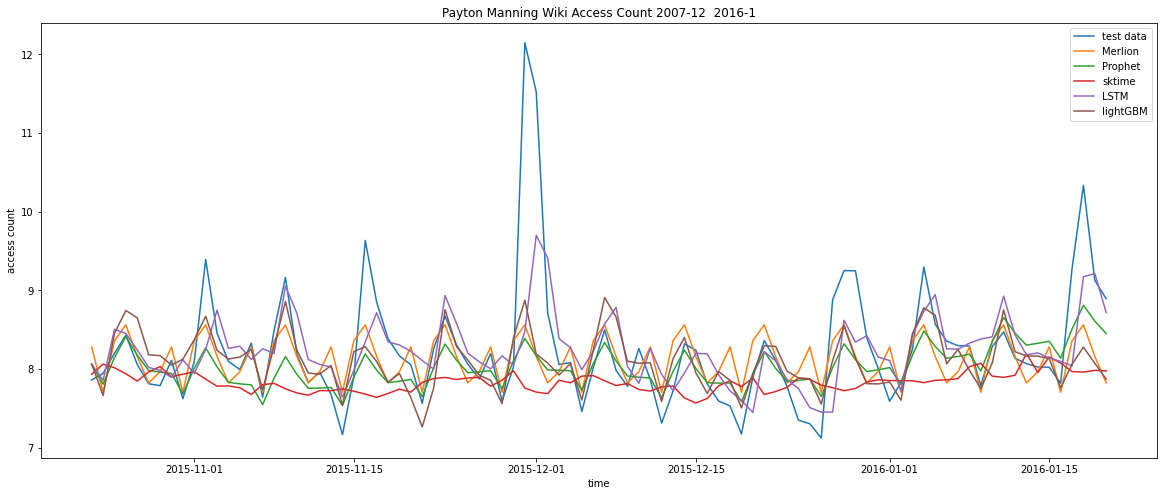

In [55]:
# 全グラフ表示
fig = plt.figure(figsize=(20, 8))

plt.title("Payton Manning Wiki Access Count 2007-12  2016-1")
plt.xlabel("time")
plt.ylabel("access count")

plt.plot(test["ds"], test["y"], label="test data")
plt.plot(test["ds"], pred_merlion.to_pd(), label="Merlion") # Merlion
plt.plot(test["ds"], pred_prophet, label="Prophet") # Prophet
plt.plot(test["ds"], pred_sktime, label="sktime") # sktime
plt.plot(test["ds"], pred_lstm, label="LSTM") # LSTM
plt.plot(test["ds"], pred_lgbm, label="lightGBM") # lightGBM

plt.legend()
plt.show()

In [56]:
for i in ['Merlion', 'Prophet', 'sktime', 'LSTM', 'lightGBM']:
    print(i)
    print("R2スコア",r2_score(compare_pred["test_data"], compare_pred[i]))
    print("RMSE", np.sqrt(mean_squared_error(compare_pred["test_data"], compare_pred[i])),"\n")

Merlion
R2スコア 0.2024673792611913
RMSE 0.6990555856934613 

Prophet
R2スコア 0.22214304369582694
RMSE 0.6903786500518649 

sktime
R2スコア -0.33466817117596226
RMSE 0.9043241612176715 

LSTM
R2スコア 0.3802514812581941
RMSE 0.6162333966476304 

lightGBM
R2スコア 0.23790827835953354
RMSE 0.6833467046462421 

